## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [16]:
from keras.layers import BatchNormalization
    
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [17]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [18]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""

reduce_lr_factor = [0.1,0.5,0.9]
redice_lr_patient = [1,5,10]

In [20]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.10, reduce_patient: 1


W0729 13:49:02.364802 16504 deprecation.py:323] From C:\Users\sabri\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
__________

Epoch 14/25
50000/50000 [==============================] - 6s 112us/step - loss: 1.2365 - acc: 0.5690 - val_loss: 1.4682 - val_acc: 0.4797
Epoch 15/25
50000/50000 [==============================] - 5s 107us/step - loss: 1.2168 - acc: 0.5770 - val_loss: 1.4609 - val_acc: 0.4870
Epoch 16/25
50000/50000 [==============================] - 6s 110us/step - loss: 1.1956 - acc: 0.5852 - val_loss: 1.4570 - val_acc: 0.4899
Epoch 17/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.1766 - acc: 0.5911 - val_loss: 1.4459 - val_acc: 0.4929
Epoch 18/25
50000/50000 [==============================] - 6s 119us/step - loss: 1.1569 - acc: 0.5994 - val_loss: 1.4451 - val_acc: 0.4987
Epoch 19/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.1392 - acc: 0.6068 - val_loss: 1.4519 - val_acc: 0.4935
Epoch 20/25
50000/50000 [==============================] - 6s 111us/step - loss: 1.1212 - acc: 0.6127 - val_loss: 1.4485 - val_acc: 0.4875
Epoch 21/25
50000/50000 [==

50000/50000 [==============================] - 7s 134us/step - loss: 2.2290 - acc: 0.2644 - val_loss: 2.1786 - val_acc: 0.3035
Epoch 2/25
50000/50000 [==============================] - 6s 111us/step - loss: 1.7783 - acc: 0.3813 - val_loss: 1.8752 - val_acc: 0.3617
Epoch 3/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.6481 - acc: 0.4236 - val_loss: 1.7317 - val_acc: 0.3950
Epoch 4/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.5730 - acc: 0.4481 - val_loss: 1.6442 - val_acc: 0.4304
Epoch 5/25
50000/50000 [==============================] - 6s 123us/step - loss: 1.5154 - acc: 0.4693 - val_loss: 1.6093 - val_acc: 0.4352
Epoch 6/25
50000/50000 [==============================] - 6s 111us/step - loss: 1.4714 - acc: 0.4868 - val_loss: 1.5743 - val_acc: 0.4500
Epoch 7/25
50000/50000 [==============================] - 6s 110us/step - loss: 1.4322 - acc: 0.5002 - val_loss: 1.5572 - val_acc: 0.4593
Epoch 8/25
50000/50000 [=====================

50000/50000 [==============================] - 6s 114us/step - loss: 1.0620 - acc: 0.6366 - val_loss: 1.4508 - val_acc: 0.4889
Epoch 25/25
50000/50000 [==============================] - 6s 112us/step - loss: 1.0455 - acc: 0.6448 - val_loss: 1.4579 - val_acc: 0.4880
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_19 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normaliza

50000/50000 [==============================] - 5s 106us/step - loss: 1.3176 - acc: 0.5376 - val_loss: 1.5048 - val_acc: 0.4709
Epoch 12/25
50000/50000 [==============================] - 5s 103us/step - loss: 1.2935 - acc: 0.5471 - val_loss: 1.5059 - val_acc: 0.4717
Epoch 13/25
50000/50000 [==============================] - 5s 106us/step - loss: 1.2700 - acc: 0.5555 - val_loss: 1.4904 - val_acc: 0.4743
Epoch 14/25
50000/50000 [==============================] - 6s 113us/step - loss: 1.2490 - acc: 0.5637 - val_loss: 1.4762 - val_acc: 0.4819
Epoch 15/25
50000/50000 [==============================] - 6s 113us/step - loss: 1.2280 - acc: 0.5718 - val_loss: 1.4662 - val_acc: 0.4851
Epoch 16/25
50000/50000 [==============================] - 6s 113us/step - loss: 1.2071 - acc: 0.5803 - val_loss: 1.4926 - val_acc: 0.4776
Epoch 17/25
50000/50000 [==============================] - 6s 111us/step - loss: 1.1875 - acc: 0.5868 - val_loss: 1.4616 - val_acc: 0.4897
Epoch 18/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 152us/step - loss: 2.2380 - acc: 0.2682 - val_loss: 2.0726 - val_acc: 0.3126
Epoch 2/25
50000/50000 [==============================] - 6s 110us/step - loss: 1.7572 - acc: 0.3908 - val_loss: 1.8358 - val_acc: 0.3693
Epoch 3/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.6278 - acc: 0.4306 - val_loss: 1.7283 - val_acc: 0.3960
Epoch 4/25
50000/50000 [==============================] - 6s 110us/step - loss: 1.5561 - acc: 0.4558 - val_loss: 1.6798 - val_acc: 0.4121
Epoch 5/25
50000/50000 [==============================] - 6s 113us/step - loss: 1.5033 - acc: 0.4738 - val_loss: 1.6200 - val_acc: 0.4290
Epoch 6/25
50000/50000 [==============================] - 6s 110us/step - loss: 1.4579 - acc: 0.4913 - val_loss: 1.5909 - val_acc: 0.4451
Epoch 7/25
50000/50000 [==============================] - 6s 110us/step - loss: 1.4211 - acc: 0.5039 - val_loss: 1.5613 - 

Epoch 23/25
50000/50000 [==============================] - 6s 121us/step - loss: 0.4064 - acc: 0.8839 - val_loss: 1.6263 - val_acc: 0.5223
Epoch 24/25
50000/50000 [==============================] - 6s 115us/step - loss: 0.3921 - acc: 0.8894 - val_loss: 1.6722 - val_acc: 0.5173
Epoch 25/25
50000/50000 [==============================] - 6s 112us/step - loss: 0.3744 - acc: 0.8953 - val_loss: 1.6546 - val_acc: 0.5225

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Numbers of exp: 10, reduce_factor: 0.10, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_34 (Batc (None, 256)       

50000/50000 [==============================] - 6s 123us/step - loss: 1.1712 - acc: 0.5976 - val_loss: 1.4340 - val_acc: 0.4915
Epoch 10/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.1443 - acc: 0.6063 - val_loss: 1.4422 - val_acc: 0.4867
Epoch 11/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.1168 - acc: 0.6168 - val_loss: 1.4424 - val_acc: 0.4850
Epoch 12/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.0931 - acc: 0.6279 - val_loss: 1.4860 - val_acc: 0.4820
Epoch 13/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.0692 - acc: 0.6353 - val_loss: 1.4473 - val_acc: 0.4886
Epoch 14/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.0475 - acc: 0.6446 - val_loss: 1.4207 - val_acc: 0.4990
Epoch 15/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.0254 - acc: 0.6529 - val_loss: 1.4464 - val_acc: 0.4877
Epoch 16/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 172us/step - loss: 2.0037 - acc: 0.3240 - val_loss: 2.0031 - val_acc: 0.3401
Epoch 2/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.6345 - acc: 0.4270 - val_loss: 1.7353 - val_acc: 0.3919
Epoch 3/25
50000/50000 [==============================] - 6s 120us/step - loss: 1.5367 - acc: 0.4610 - val_loss: 1.6673 - val_acc: 0.4159
Epoch 4/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.4757 - acc: 0.4846 - val_loss: 1.6244 - val_acc: 0.4302
Epoch 5/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.4296 - acc: 0.5001 - val_loss: 1.5662 - val_acc: 0.4468
Epoch 6/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.3931 - acc: 0.5142 - val_loss: 1.5647 - val_acc: 0.4496
Epoch 7/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.3616 - acc: 0.5244 - val_loss: 1.5314 - 

Epoch 24/25
50000/50000 [==============================] - 6s 122us/step - loss: 1.0536 - acc: 0.6442 - val_loss: 1.4338 - val_acc: 0.4942
Epoch 25/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.0400 - acc: 0.6498 - val_loss: 1.4289 - val_acc: 0.5000
Numbers of exp: 15, reduce_factor: 0.90, reduce_patient: 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_49 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
bat

50000/50000 [==============================] - 6s 126us/step - loss: 1.2669 - acc: 0.5624 - val_loss: 1.4860 - val_acc: 0.4742
Epoch 12/25
50000/50000 [==============================] - 6s 124us/step - loss: 1.2476 - acc: 0.5696 - val_loss: 1.4827 - val_acc: 0.4764
Epoch 13/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.2283 - acc: 0.5769 - val_loss: 1.4787 - val_acc: 0.4768
Epoch 14/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.2096 - acc: 0.5837 - val_loss: 1.4650 - val_acc: 0.4866
Epoch 15/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.1941 - acc: 0.5896 - val_loss: 1.4559 - val_acc: 0.4913
Epoch 16/25
50000/50000 [==============================] - 6s 123us/step - loss: 1.1780 - acc: 0.5934 - val_loss: 1.4621 - val_acc: 0.4874
Epoch 17/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.1626 - acc: 0.6013 - val_loss: 1.4560 - val_acc: 0.4842
Epoch 18/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 181us/step - loss: 1.8345 - acc: 0.3713 - val_loss: 2.0867 - val_acc: 0.3441
Epoch 2/25
50000/50000 [==============================] - 6s 119us/step - loss: 1.5270 - acc: 0.4609 - val_loss: 1.8825 - val_acc: 0.3548
Epoch 3/25
50000/50000 [==============================] - 6s 119us/step - loss: 1.4152 - acc: 0.4983 - val_loss: 1.8787 - val_acc: 0.3804
Epoch 4/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.3341 - acc: 0.5262 - val_loss: 2.1402 - val_acc: 0.3294
Epoch 5/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.2646 - acc: 0.5522 - val_loss: 1.7314 - val_acc: 0.4093
Epoch 6/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.2088 - acc: 0.5724 - val_loss: 1.7228 - val_acc: 0.4091
Epoch 7/25
50000/50000 [==============================] - 6s 120us/step - loss: 1.1594 - acc: 0.5900 - val_loss: 1.6852 - 

50000/50000 [==============================] - 6s 118us/step - loss: 0.6873 - acc: 0.7813 - val_loss: 1.5118 - val_acc: 0.4962
Epoch 23/25
50000/50000 [==============================] - 6s 117us/step - loss: 0.6709 - acc: 0.7876 - val_loss: 1.4780 - val_acc: 0.5044
Epoch 24/25
50000/50000 [==============================] - 6s 115us/step - loss: 0.6514 - acc: 0.7952 - val_loss: 1.5413 - val_acc: 0.4857
Epoch 25/25
50000/50000 [==============================] - 6s 116us/step - loss: 0.6389 - acc: 0.7986 - val_loss: 1.5341 - val_acc: 0.4906
Numbers of exp: 20, reduce_factor: 0.10, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________


Epoch 9/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.3435 - acc: 0.5328 - val_loss: 1.5517 - val_acc: 0.4496
Epoch 10/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.3116 - acc: 0.5436 - val_loss: 1.5354 - val_acc: 0.4555
Epoch 11/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.2834 - acc: 0.5559 - val_loss: 1.5583 - val_acc: 0.4506
Epoch 12/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.2561 - acc: 0.5658 - val_loss: 1.5570 - val_acc: 0.4486
Epoch 13/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.2319 - acc: 0.5751 - val_loss: 1.5288 - val_acc: 0.4646
Epoch 14/25
50000/50000 [==============================] - 6s 120us/step - loss: 1.2087 - acc: 0.5831 - val_loss: 1.4988 - val_acc: 0.4757
Epoch 15/25
50000/50000 [==============================] - 6s 119us/step - loss: 1.1864 - acc: 0.5897 - val_loss: 1.5087 - val_acc: 0.4657
Epoch 16/25
50000/50000 [===

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 10s 196us/step - loss: 2.1317 - acc: 0.2876 - val_loss: 2.0468 - val_acc: 0.3105
Epoch 2/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.7766 - acc: 0.3806 - val_loss: 1.9014 - val_acc: 0.3507
Epoch 3/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.6516 - acc: 0.4235 - val_loss: 1.7574 - val_acc: 0.3889
Epoch 4/25
50000/50000 [==============================] - 6s 122us/step - loss: 1.5713 - acc: 0.4504 - val_loss: 1.6757 - val_acc: 0.4132
Epoch 5/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.5087 - acc: 0.4718 - val_loss: 1.6108 - val_acc: 0.4341
Epoch 6/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.4586 - acc: 0.4910 - val_loss: 1.5786 - val_acc: 0.4500
Epoch 7/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.4148 - acc: 0.5058 - val_loss: 1.5846 -

Epoch 24/25
50000/50000 [==============================] - 6s 119us/step - loss: 1.0130 - acc: 0.6589 - val_loss: 1.5016 - val_acc: 0.4771
Epoch 25/25
50000/50000 [==============================] - 6s 124us/step - loss: 0.9960 - acc: 0.6634 - val_loss: 1.4839 - val_acc: 0.4919
Numbers of exp: 25, reduce_factor: 0.90, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_79 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
bat

50000/50000 [==============================] - 6s 128us/step - loss: 1.2851 - acc: 0.5554 - val_loss: 1.5348 - val_acc: 0.4573
Epoch 12/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.2598 - acc: 0.5631 - val_loss: 1.5018 - val_acc: 0.4688
Epoch 13/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.2335 - acc: 0.5724 - val_loss: 1.5592 - val_acc: 0.4586
Epoch 14/25
50000/50000 [==============================] - 6s 124us/step - loss: 1.2106 - acc: 0.5818 - val_loss: 1.5068 - val_acc: 0.4721
Epoch 15/25
50000/50000 [==============================] - 6s 130us/step - loss: 1.1864 - acc: 0.5902 - val_loss: 1.5260 - val_acc: 0.4626
Epoch 16/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.1662 - acc: 0.5989 - val_loss: 1.5231 - val_acc: 0.4719
Epoch 17/25
50000/50000 [==============================] - 6s 123us/step - loss: 1.1467 - acc: 0.6050 - val_loss: 1.4761 - val_acc: 0.4820
Epoch 18/25
50000/50000 [==============

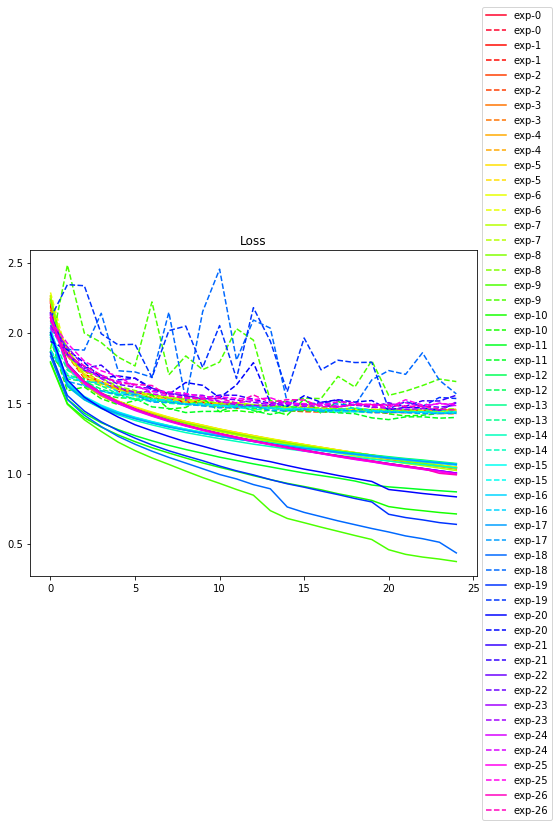

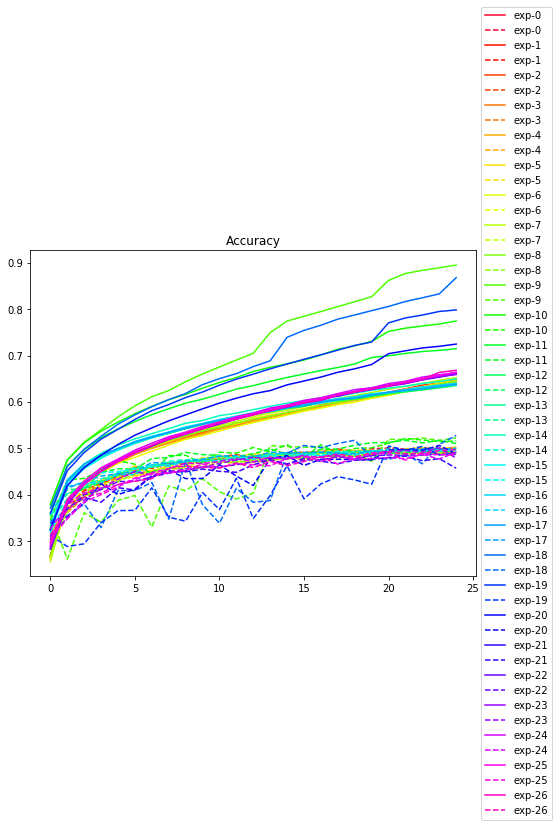

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()